# Executive summary

## Business Goals

In recent years, construction accidents happens a lot in Singapore and other countries worldwide. It results in significant human suffering, lagged project schedule, damaged reputation of the company and industry involved and other negative influence. Therefore, some indicators, inspection findings, audit score and safety climate survey are proposed to help construction-related organizations. Due to the unreliability of these indicators, we have to mine some useful data in a Fatality and Catastrophe Investigation Summary to pinpoint occupations and workplace activities that face higher safety risks than others.

## Findings

Based on the result of analysis, we find that (add some noticeable findings)

It is recommended that some appropriate measures to mitigate the identified risks and prevent the occurrence of similar accidents.

# Introduction

## Purpose of analysis

In recent years, the construction industry remains the top contributor for workplace fatalities in Singapore. Likewise, poor construction safety performance is common to see in other countries, which causes significant human suffering, property damage and great time consumption. To improve construction safety performance, many have proposed the use of leading indicators such as inspection findings, audit score and safety climate survey. But the reliability of these indicators are still not validated. Thus, a Fatality and Catastrophe Investigation Summary is mined to identify higher safety risks occupations and work place activities.

## Business & Text Mining goals

To realize our business target, which is to reduce construction accidents, we need to answer below questions in details:

1. Which type of accidents (in terms of main causes) are more common in fatal or catastrophic accidents?

2. What are the more risky occupations in such accidents?

3. Which parts of human body are more prone to be injured in such accidents.

4. What are the common activities that the victims were engaged in prior to the accident?

Virtually, these four questions can be converted into four text mining goals:

- Identify the most frequent type of accidents in fatal or catastrophic accidents.

- Identify high-risk occupations in fatal or catastrophic accidents.

- Identify high-risk injured parts of human body in fatal or catastrophic accidents.

- Identify the most common engaged activities of victims.

In this way, it is possible to take some preventative measures to reduce construction accidents.

# Main Body 

## Preprocessing

Preprocessing is an essential step for text mining before conducting the actual process. Basically, some common-used preprocessing techniques, like converting all characters to lowercase, tokenization, striping spare whitespace and pos tagging, were applied on the data. We also merge two causes "Other" and "Others" together.
In addition, since according to observation, there are a few corrupted accident records exist in osha dataset, we reobtain these records by recrawling from their source website: https://www.osha.gov/pls/imis/accidentsearch.accident_detail based on accident id.

In [25]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.tag.stanford import StanfordPOSTagger

# load data file
msia = pd.read_excel('data/MsiaAccidentCases.xlsx')
osha = pd.read_excel('data/osha.xlsx', header=None, parse_cols='A:D')

Preview raw dataset

In [26]:
msia.head(10)

,Cause,Title Case,Summary Case
0,Caught in/between Objects,Died being caught in between machines,The accident occurred as victim was assigned t...
1,Other,Died been buried,The accident occurred during the floor concret...
2,Struck By Moving Objects,Died crushed by entrance arch,Victim with four co-workers were installing wo...
3,Caught in/between Objects,Died due to mine cave-in,A series of avalanche trapped victim who was m...
4,Fires and Explosion,Died being run over by a lorry,Accident involving an employee who has been ru...
5,Fires and Explosion,Died due to explosion of boiler,Accident involving three workers were killed a...
6,Falls,Died falling off the roof,The victim and his two co-workers were perform...
7,Electrocution,Died due to electrocution,The victim was died due to electrocution. He i...
8,Falls,Died struck by falling beam,Incident occured during the workers were perfo...
9,Caught in/between Objects,Died crushed by object,"Prior to the incident, the victim and his coll..."


In [21]:
osha.head(10)

,0,1,2,3
0,201079928,Employee Is Burned By Forklift Radiator Fluid,At approximately 11:30 a.m. on November 13 2...,burn industrial truck waste proc fac pa...
1,202561825,Employee Falls From Flatbed Trailer And Later...,On August 30 2013 Employee #1 was working f...,truck flatbed truck trailer fall abdomen
2,200361855,Two Workers Are Struck By Motor Vehicle And O...,On August 27 2013 Employees #1 and #2 of T...,construction undrgrd power line highway ...
3,200361863,Employee Is Struck By Bales Of Wire And Killed,On August 26 2013 Employee #1 with Lee Iro...,waste proc fac industrial truck struck b...
4,201079324,Employee Is Splashed With Hot Water And Is Bu...,On July 14 2013 Employee #1 vacuum pump tr...,truck driver pump tank hot water struc...
5,202658258,Employee Suffers Burns While Moving Soup,On June 30 2013 Employee #1 was working in ...,burn spill arm chest abdomen
6,202685947,Employee Injures Self With Knife,An incident occurred as Employee #1 was attem...,knife puncture abdomen struck by slip ...
7,202673471,Foreman Is Fatally Crushed When Forklift Tips...,At approximately 6:30 a.m. on May 13 2013 E...,construction equipment operator industri...
8,202369575,Employee Fractures Abdomen When Run Over By T...,On April 23 2013 Employee #1 a baggage tug...,cart struck by run over fracture abdomen
9,202509832,Employee Suffers Abdominal Fracture In Fall F...,On April 9 2013 Employee #1 was installing ...,installing ladder scaffold structure mo...


Example of the corrupted value in the 2nd column of osha

In [27]:
osha[osha[1]==" Electric Shock "]

,0,1,2,3
62,14521470,Electric Shock,THE OWNER OF A COMPANY AND ONE OF HIS EMPLOYE...,electrical electrocuted electric shock ...
192,315964536,Electric Shock,On April 3 2012 an employee was working for...,electrical electrocuted overhead power l...
282,200452894,Electric Shock,At 3:30 p.m. on October 17 2011 a hotel mai...,electrical electrocuted maintenance air...
284,200171080,Electric Shock,A heating ventilation and air-conditioning ...,electrical electrocuted maintenance air...
285,200556546,Electric Shock,Two employees were repairing the compressor o...,electrical electrocuted electrician ele...
473,201363652,Electric Shock,An electrician was working on the runway ligh...,electrical electrocuted electrician ele...
640,202469953,Electric Shock,Two employees were working as laborers at an ...,electrical electric shock burn overhead...
645,200375251,Electric Shock,An electrician was inspecting the electrical ...,electrical electrocuted electrician ele...
780,202087128,Electric Shock,An engineer for a radio station was setting u...,electrical electric shock telecom work ...
847,200000453,Electric Shock,A power line crew was installing all dielectr...,electrical electrocuted elec utility wor...


Example of the corrupted value in the 3rd column of osha

In [24]:
osha[osha[2]=="InspectionOpen DateSICEstablishment Name"]

,0,1,2,3
15,201703584,Worker Is Injured When Struck By Board And Th...,InspectionOpen DateSICEstablishment Name,31592899410/31/20126531Pinnacle Construction &...
34,202614863,Employee Falls Through Ceiling Suffers Contu...,InspectionOpen DateSICEstablishment Name,31706460803/26/20137363Express Services Inc
61,14493290,Employee Asphyxiated By Nitrogen In Sandblast...,InspectionOpen DateSICEstablishment Name,10107273410/27/19872813Ref-Chem Corp
187,946731,Chemical Spill No Injuries,InspectionOpen DateSICEstablishment Name,1846386901/04/19902821Walsh Divison Colloids Inc.
246,201352788,Employee Killed When Caught Between Lift Rail...,InspectionOpen DateSICEstablishment Name,30843203806/28/20051742Mader Southeast Inc.
248,201352663,Employee Is Killed While Working In Aerial Lift,InspectionOpen DateSICEstablishment Name,30675415111/22/20041731Carter Electric Company...
294,200831634,Employee Is Sickened By Atmospheric Hazards I...,InspectionOpen DateSICEstablishment Name,31343230409/14/20111542Ruttura & Sons Construc...
305,200831469,Hydrogen Sulfide Overexposure Kills Three Wor...,InspectionOpen DateSICEstablishment Name,30763762906/29/20097699S. Dahan Piping And Hea...
347,200840916,Employee Dies From Asphyxiation,InspectionOpen DateSICEstablishment Name,30381932007/07/20031799J.F. Painting Co.
348,201922648,Two Employees Die Of Asphyxia In Undersea Oil...,InspectionOpen DateSICEstablishment Name,30457114408/30/20023731Platform Marine Inc.


In [ ]:
# standardized dataframe header
msia.columns = [name.split()[0] for name in msia.columns]
osha.columns = ['Accident', 'Title', 'Summary', 'Keywords']

# merge Other and Others by changing Others to Other
msia.loc[msia.Cause == 'Others', 'Cause'] = 'Other'

# Strip whitespace (including newlines) from each string in the Series/Index from left and right sides
for col in ['Title', 'Summary', 'Keywords']:
    osha[col] = osha[col].astype('str').str.strip()

# impute missing data from source website by recrawling
url = 'https://www.osha.gov/pls/imis/accidentsearch.accident_detail'
# find index containing missing value
is_missing = (osha.Summary == 'InspectionOpen DateSICEstablishment Name') | (
osha.Title.apply(lambda x: x.count(' ') <= 1))
length = sum(is_missing)
count = 0
print('Recrawling data for imputing...')
for index, row in osha.loc[is_missing].iterrows():
    print('%d/%d' % (count, length))
    page = requests.get(url, params={'id': row.Accident})  # get source page of missing record

    soup = BeautifulSoup(page.content, 'html.parser')
    strong = soup.select('#maincontain > div > p.text-center > strong')[0]
    td = soup.findAll("td", {"colspan": "8"})

    title = strong.text[strong.text.index('-') + 1:].strip()
    summary = td[1].text.strip()
    keywords = td[2].text[9:].strip().split(', ')

    osha.loc[index, 'Title'] = title
    osha.loc[index, 'Summary'] = summary
    osha.loc[index, 'Keywords'] = '  '.join(keywords)  # double spaces
    count += 1

# Using Stanford POS Tagger rather than nltk default pos tagger to get more accurate pos tag
pos_model_path = './stanford-postagger-full-2017-06-09/models/english-bidirectional-distsim.tagger'  #  modify soruce file path at here
pos_jar_path = './stanford-postagger-full-2017-06-09/stanford-postagger.jar'  #  modify soruce file path at here
# Initialize the tagger, the whole process wiil cost hours time
st_pos = StanfordPOSTagger(pos_model_path, pos_jar_path)
osha = pd.read_csv('data/osha_cleaned_predict.csv')
print('Start Standford POS Tagging for Title...')
osha['Title_POS'] = osha.Title.apply(lambda x: st_pos.tag(word_tokenize(x.lower())))
# osha.to_csv('../rawdata/osha_cleaned_pos.csv', index=False)
print('Start Standford POS Tagging for Summary...')
osha['Summary_POS'] = osha.Summary.apply(lambda x: st_pos.tag(word_tokenize(x.lower())))
# osha.to_csv('./data/osha_cleaned_pos.csv', index=False)

# save to file
# msia.to_csv('data/MsiaAccidentCases_cleaned.csv', index=False)

Preview preprocessed dataset

In [31]:
msia.head(10)

,Cause,Title,Summary
0,Caught in/between Objects,Died being caught in between machines,The accident occurred as victim was assigned t...
1,Other,Died been buried,The accident occurred during the floor concret...
2,Struck By Moving Objects,Died crushed by entrance arch,Victim with four co-workers were installing wo...
3,Caught in/between Objects,Died due to mine cave-in,A series of avalanche trapped victim who was m...
4,Fires and Explosion,Died being run over by a lorry,Accident involving an employee who has been ru...
5,Fires and Explosion,Died due to explosion of boiler,Accident involving three workers were killed a...
6,Falls,Died falling off the roof,The victim and his two co-workers were perform...
7,Electrocution,Died due to electrocution,The victim was died due to electrocution. He i...
8,Falls,Died struck by falling beam,Incident occured during the workers were perfo...
9,Caught in/between Objects,Died crushed by object,"Prior to the incident, the victim and his coll..."


In [30]:
osha.head(10)

,Accident,Title,Summary,Keywords,Title_POS,Summary_POS
0,201079928,Employee Is Burned By Forklift Radiator Fluid,At approximately 11:30 a.m. on November 13 20...,burn industrial truck waste proc fac paper ...,"[('employee', 'NN'), ('is', 'VBZ'), ('burned',...","[('at', 'IN'), ('approximately', 'RB'), ('11:3..."
1,202561825,Employee Falls From Flatbed Trailer And Later ...,On August 30 2013 Employee #1 was working fr...,truck flatbed truck trailer fall abdomen,"[('employee', 'NN'), ('falls', 'VBZ'), ('from'...","[('on', 'IN'), ('august', 'NNP'), ('30', 'CD')..."
2,200361855,Two Workers Are Struck By Motor Vehicle And On...,On August 27 2013 Employees #1 and #2 of Te...,construction undrgrd power line highway tra...,"[('two', 'CD'), ('workers', 'NNS'), ('are', 'V...","[('on', 'IN'), ('august', 'NNP'), ('27', 'CD')..."
3,200361863,Employee Is Struck By Bales Of Wire And Killed,On August 26 2013 Employee #1 with Lee Iron...,waste proc fac industrial truck struck by u...,"[('employee', 'NN'), ('is', 'VBZ'), ('struck',...","[('on', 'IN'), ('august', 'NNP'), ('26', 'CD')..."
4,201079324,Employee Is Splashed With Hot Water And Is Burned,On July 14 2013 Employee #1 vacuum pump tru...,truck driver pump tank hot water struck by...,"[('employee', 'NN'), ('is', 'VBZ'), ('splashed...","[('on', 'IN'), ('july', 'NNP'), ('14', 'CD'), ..."
5,202658258,Employee Suffers Burns While Moving Soup,On June 30 2013 Employee #1 was working in a...,burn spill arm chest abdomen,"[('employee', 'NN'), ('suffers', 'VBZ'), ('bur...","[('on', 'IN'), ('june', 'NNP'), ('30', 'CD'), ..."
6,202685947,Employee Injures Self With Knife,An incident occurred as Employee #1 was attemp...,knife puncture abdomen struck by slip tai...,"[('employee', 'NN'), ('injures', 'VBZ'), ('sel...","[('an', 'DT'), ('incident', 'NN'), ('occurred'..."
7,202673471,Foreman Is Fatally Crushed When Forklift Tips ...,At approximately 6:30 a.m. on May 13 2013 Em...,construction equipment operator industrial t...,"[('foreman', 'NN'), ('is', 'VBZ'), ('fatally',...","[('at', 'IN'), ('approximately', 'RB'), ('6:30..."
8,202369575,Employee Fractures Abdomen When Run Over By Tu...,On April 23 2013 Employee #1 a baggage tug ...,cart struck by run over fracture abdomen,"[('employee', 'NN'), ('fractures', 'NNS'), ('a...","[('on', 'IN'), ('april', 'NNP'), ('23', 'CD'),..."
9,202509832,Employee Suffers Abdominal Fracture In Fall Fr...,On April 9 2013 Employee #1 was installing v...,installing ladder scaffold structure moving...,"[('employee', 'NN'), ('suffers', 'VBZ'), ('abd...","[('on', 'IN'), ('april', 'NNP'), ('9', 'CD'), ..."


## Which parts of human body are more prone to be injured in such accidents?

To extract common injured human body parts in accidents, we first observe the preprocessed dataset and we found that at most cases, the Keywords column contain human body parts information. Hence, we split each Keywords column and match the created term list with the prepared human body terms list crawling from internet and conduct statistic on the result.

Top 10 common injured of human body parts for OSHA dataset:


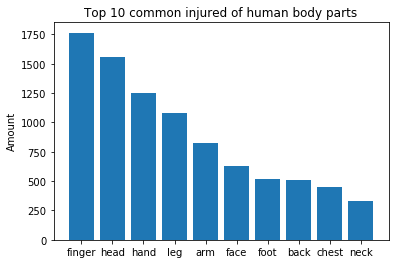

finger:	1764
head:	1556
hand:	1249
leg:	1081
arm:	821
face:	629
foot:	515
back:	512
chest:	447
neck:	333
OSHA injured of human body parts word cloud:


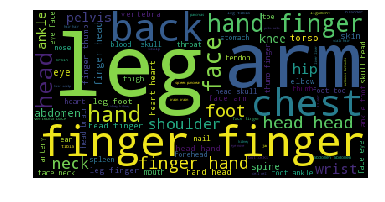

In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import pickle
from collections import Counter
import numpy as np

# load body terms list
try:
    human_body_terms = pickle.load(open("data/human_body_terms.pk", "rb"))
except FileNotFoundError:
    page = requests.get('http://www.enchantedlearning.com/wordlist/body.shtml')
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find('table', {'border': '1'})
    tds = table.findAll("td")
    [center.extract() for td in tds for center in td.findAll('center')]
    human_body_terms = [term for td in tds for term in re.split('\n+', td.text.strip())]
    pickle.dump(human_body_terms, open("data/human_body_terms.pk", "wb"))


def get_body_parts(text):
    '''
    Extract human body term from input
    :param text: str
    :return: list containing body terms
    '''
    keywords = text.split()
    body_parts = [k for k in keywords if k in human_body_terms]
    if body_parts:
        return body_parts


if __name__ == "__main__":
    osha_body_parts = osha.Keywords.apply(get_body_parts)

    osha_body_parts = osha_body_parts.dropna()  # remove all None value

    # visualization
    print('Top 10 common injured of human body parts for OSHA dataset:')
    osha_body_parts_statistic = {}
    for parts in osha_body_parts:
        for part in parts:
            if part not in osha_body_parts_statistic:
                osha_body_parts_statistic.update({part: 1})
            else:
                osha_body_parts_statistic[part] += 1
    top_10 = Counter(osha_body_parts_statistic).most_common(10)  # find top 10 common injured of human body parts
    objects = tuple([o for o, c in top_10])
    y_pos = np.arange(len(objects))
    count = [c for o, c in top_10]
    plt.bar(y_pos, count)
    plt.xticks(y_pos, objects)
    plt.ylabel('Amount')
    plt.title('Top 10 common injured of human body parts')
    plt.show()
    for o, c in top_10: print('%s:\t%d' % (o, c))

    # TODO check wordcloud why occur repeated words
    print('OSHA injured of human body parts word cloud:')
    osha_word_string = ' '.join([' '.join(w) for w in osha_body_parts])
    osha_word_cloud = WordCloud().generate(osha_word_string)
    plt.imshow(osha_word_cloud)
    plt.axis('off')
    plt.show()
    print